# Hospital insurance analysis

1. Import packages
2. Read data
3. EDA
4. Model

**Variables:**
* age
* sex
* bmi
* children
* smoker
* region
* expenses

# Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import ttest_ind
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

In [2]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] =  (12,10)

# Read data

In [3]:
#reading data
insurance = pd.read_csv("../input/insurance-dataset-regression-analysis/insurance.csv")
shape = insurance.shape
print("successfully read")
print("we have {} rows and {} columns\n".format(shape[0],shape[1]))
print("columns types")
insurance.head()

successfully read
we have 1338 rows and 7 columns

columns types


,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86


In [4]:
print("number of missing values\n") 
insurance.isnull().sum()

number of missing values



age         0
sex         0
bmi         0
children    0
smoker      0
region      0
expenses    0
dtype: int64

# EDA


The goal of this pairplot is to check: 

1.   the nature of relationship with EXPENSES
2.   if quadratic relationship is present we could add a quadratic term to our model to avoid misspecification error.
3. Check for skewed data, if any we could consider taking the Log or even scale them.



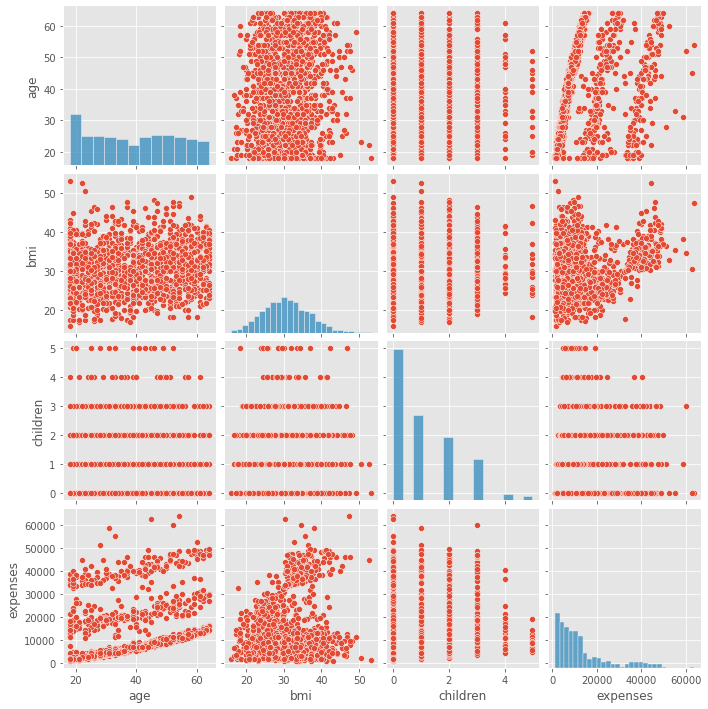

In [5]:
sns.pairplot(insurance)
plt.show()

One can gain a lot of insights from this graph.

Observing the last row, one could examine the relationship of some variables with EXPENSES.
1. AGE shows a positive, moderate relationship with EXPENSES for certain Stratum (levels) of EXPENSES. maybe a model with different intercepts.
2. BMI does not show a clear relationship with EXPENSES
3. CHILDREN this is not an appropriate graph for it, however it is indicative of the nature of relationship with EXPENSES. No clear relationship with expenses. This could be appropriately analyzed with a boxplot and tested formally using ANOVA.


In addition to this looking at the histograms on the main diagonal. One could clearly observe the distribution of certain variables.

1.  Reagarding the BMI it follows a textbook normal distribution (add how this might help with the probability model)
2.   EXPENSES does not follow a normal distribution. This might cause problems in the future when checking the Stochastic part assumption (rephrase more)
3. We could consider taking the log to remedy this effect. A Log-Linear model.

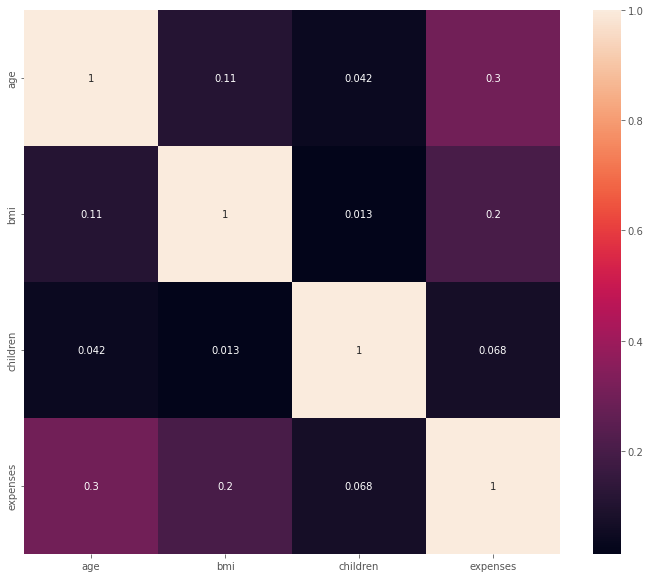

In [6]:
cor = insurance.corr()
sns.heatmap(data = cor, annot = True)
plt.show()

In [7]:
lst = ['age' , 'bmi']
dic = {}
for idx, c in enumerate(lst):
    test = pearsonr(insurance.loc[:,c], insurance['expenses'])
    dic[c] = test
print(dic)

{'age': (0.2990081922850828, 4.8866955899922605e-29), 'bmi': (0.19857625501893203, 2.301828073512984e-13)}


This is test is basically checking whether the sample's pearson correlation coefficient is equal to zero or not. 

Reagarding Categorical variables. One could use Boxplot to examine the relationship with expenses.
A similar graph to observe the categorical variables.


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-package

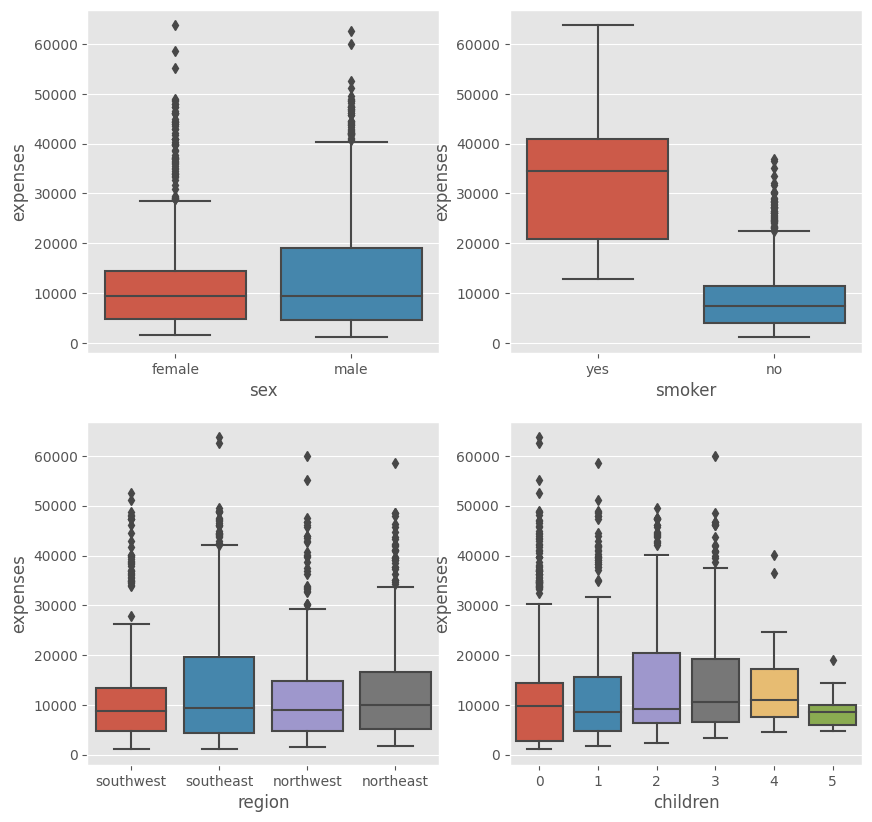

In [8]:
plt.figure(figsize = (10, 10), dpi = 100)


plt.subplot(2,2,1)
sns.boxplot(insurance['sex'], insurance['expenses'])

plt.subplot(2,2,2)
sns.boxplot(insurance['smoker'], insurance['expenses'])

plt.subplot(2,2,3)
sns.boxplot(insurance['region'], insurance['expenses'])

plt.subplot(2,2,4)
sns.boxplot(insurance['children'], insurance['expenses'])
plt.show()

what can we see from this plot?
For every variable the 'Median' level of EXPENSES does not change with different categories except for the SMOKER variable.


To formally test the significance of each variable. We could apply ANOVA for REGION, CHILDREN, and a t-test for SEX, SMOKER as these indicator variables.

However, this is a redundant step, as the graph says a lot; SMOKER seems to be the only variable that is sginificant. 

In [9]:
df_smokers =  insurance.groupby('smoker')   #grouping by smoker column
non_smokers = df_smokers.get_group('no').expenses   #access
smokers = df_smokers.get_group('yes').expenses

print('smokers \n', smokers.head(),'\n-----------\n non-smokers\n', non_smokers.head())

smokers 
 0     16884.92
11    27808.73
14    39611.76
19    36837.47
23    37701.88
Name: expenses, dtype: float64 
-----------
 non-smokers
 1     1725.55
2     4449.46
3    21984.47
4     3866.86
5     3756.62
Name: expenses, dtype: float64


In [10]:
ttest_ind(smokers, non_smokers)

Ttest_indResult(statistic=46.6649210792002, pvalue=8.271449574495316e-283)

Note this is a two tailed test.The pvalue obtained is less than the critical value of 0.025 


Construct our regression model knowing that the only significant variable from the above analysis is SMOKER, but first, we need to encode our variables divide the train and test data.


In [11]:
X = insurance.iloc[:,:-1]
y = insurance.iloc[:,-1]  

In [12]:
X = pd.get_dummies(data = X, columns = ['sex', 'smoker', 'region', 'children'], drop_first = True)

In [13]:
X = sm.add_constant(X)   # add intercept in Statsmodels 
X.head() 

,const,age,bmi,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,children_1,children_2,children_3,children_4,children_5
0,1.0,19,27.9,0,1,0,0,1,0,0,0,0,0
1,1.0,18,33.8,1,0,0,1,0,1,0,0,0,0
2,1.0,28,33.0,1,0,0,1,0,0,0,1,0,0
3,1.0,33,22.7,1,0,1,0,0,0,0,0,0,0
4,1.0,32,28.9,1,0,1,0,0,0,0,0,0,0


# Model

### Statsmodels
statsmodels api performs linear regression the same way as sklearn(Normal Equations) and displays the coefficients, construct confidence interval, durbin Watson statistic, and a lot more.


Fit entire model to see the relationships between the covariates and the target.


In [14]:
model_1 = sm.OLS(exog = X, endog = y).fit()
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               expenses   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     334.7
Date:                Wed, 27 Jul 2022   Prob (F-statistic):               0.00
Time:                        16:16:39   Log-Likelihood:                -13545.
No. Observations:                1338   AIC:                         2.712e+04
Df Residuals:                    1325   BIC:                         2.718e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1.193e+04    993.663    -12.007      0.000   -1.39e+04   -9981.277
age                257.1773     11.914     21.586      0.000     233.805     280.550
bmi                337.0122     28.611     11.779      0.000     280.884     393.140
sex_male          -128.2180    332.823     -0.385      0.700    -781.136     524.700
smoker_yes        2.384e+04    414.124     57.556      0.000     2.3e+04    2.46e+04
region_northwest  -379.8457    476.543     -0.797      0.426   -1314.707     555.016
region_southeast -1033.7898    479.128     -2.158      0.031   -1973.721     -93.858
region_southwest  -952.1955    478.132     -1.991      0.047   -1890.173     -14.218
children_1         391.8552    421.337      0.930      0.353    -434.705    1218.415
children_2        1636.4881    466.653      3.507      0.000     721.028    2551.948
children_3         964.0397    548.080      1.759      0.079    -111.159    2039.238
children_4        2949.2909   1239.119      2.380      0.017     518.442    5380.140
children_5        1118.6459   1455.973      0.768      0.442   -1737.619    3974.910
==============================================================================
Omnibus:                      294.111   Durbin-Watson:                   2.084
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              696.223
Skew:                           1.191   Prob(JB):                    6.56e-152
Kurtosis:                       5.610   Cond. No.                         453.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
model_2 = sm.OLS(exog = X.loc[:,['age', 'smoker_yes', 'const']], endog = np.log(y)).fit()
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               expenses   R-squared:                       0.740
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     1895.
Date:                Wed, 27 Jul 2022   Prob (F-statistic):               0.00
Time:                        16:16:39   Log-Likelihood:                -885.76
No. Observations:                1338   AIC:                             1778.
Df Residuals:                    1335   BIC:                             1793.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age            0.0357      0.001     38.994      0.000       0.034       0.037
smoker_yes     1.5469      0.032     48.607      0.000       1.484       1.609
const          7.3839      0.039    190.373      0.000       7.308       7.460
==============================================================================
Omnibus:                      354.635   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1032.838
Skew:                           1.339   Prob(JB):                    5.27e-225
Kurtosis:                       6.369   Cond. No.                         130.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

when patients age by a year costs increase by **0.03%** on average holding everything constant. Alternatively, patients who are 40 years old cost **0.7%** more than 20 year olds. In adition to this, smokers cost **1.53%** more than non-smoker. 